**Description**: Histograms and p-values for each dataset.

**Estimated runtime**: ~10 sec.

In [1]:
import os
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.stats import permutation_test
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which model and which number of test observations do you want to analyze?

In [3]:
accuracies_home_dir = "accuracies_zero_shot"
model = "mistral-qlora-zero-shot"
num_train: int = 100  # technically 0, sorry
num_test: int = 100

# Load data

In [4]:
accuracies_dir = os.path.join(
    accuracies_home_dir, f"m{num_train}", f"n{num_test}", model
)
accuracy_df = utils.load_accuracies(accuracies_dir)

# Analysis

Below are the distributions of $\text{acc}_{\text{base}}$, $\text{acc}_{\text{extra}}$,
and $\text{acc}_{\text{test}}$, and the p-value corresponding to the following
statistical test:

$$
\begin{align*}
H_0&: \text{E}[\text{acc}_{\text{test}} - \text{acc}_{\text{extra}}] = 0 \\
H_1&: \text{E}[\text{acc}_{\text{test}} - \text{acc}_{\text{extra}}] > 0.
\end{align*}
$$

The p-value is estimated via permutation testing. It's then adjusted to control the
false discovery rate.

Some care has to be taken when attempting to analyze or interpret
$\text{acc}_\text{extra} - \text{acc}_\text{base}$ and $\text{acc}_\text{test} -
\text{acc}_\text{extra}$ *together*. That's because these differences are not
independent: if $\text{acc}_\text{extra}$ is high, then $\text{acc}_\text{extra} -
\text{acc}_\text{base}$ is high and $\text{acc}_\text{test} - \text{acc}_\text{extra}$
is low. We won't analyze the scores together, per se. We only really care about
$\text{acc}_\text{test} - \text{acc}_\text{extra}$. $\text{acc}_\text{extra} -
\text{acc}_\text{base}$ only exists to sanity check that the pretraining code works;
there is an effect to detect.

In [5]:
def _plot_histograms(
    dataset: str,
    df: pl.DataFrame,
    num_classes: int,
    majority_accuracy: float,
    show_majority_accuracy_legend: bool = False,
):
    fig, axes = plt.subplots(
        nrows=len(df.columns), ncols=1, figsize=(6, len(df.columns) * 1.5)
    )
    axes = cast(list[plt.Axes], axes)

    colors = sns.color_palette()

    # Plot KDE for each column
    for i, column in enumerate(df.columns):
        ax = axes[i]
        ax.set_xlim(0, 1)
        sns.kdeplot(df[column], ax=ax, color=colors[i], fill=True)
        ax.set_xlabel(f"$\\text{{acc}}_\\text{{{column}}}$")
        ax.set_ylabel("density")
        ax.set_yticks([])
        if show_majority_accuracy_legend:
            # Option 3 from here: https://stackoverflow.com/a/4701285/18758987
            vline_label = "majority accuracy" if i == len(df.columns) - 1 else None
        else:
            vline_label = None
        ax.axvline(majority_accuracy, *ax.get_ylim(), label=vline_label, color="k")
        if show_majority_accuracy_legend:
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    if show_majority_accuracy_legend:
        fig.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig.suptitle(f"Dataset: {dataset}, # classes = {num_classes}", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(hspace=1.2)

In [6]:
def individual_analysis(
    dataset: str, df: pl.DataFrame, num_classes: int, majority_accuracy: float
) -> float:
    p_value: float = permutation_test(
        data=(df["test"], df["extra"]),
        statistic=lambda x, y: np.mean(x - y),
        alternative="greater",  # acc_test > acc_extra
        permutation_type="samples",  # paired observations
        n_resamples=10_000,
    ).pvalue
    # print(f"p-value: {p_value}")
    # print()

    _plot_histograms(dataset, df, num_classes, majority_accuracy)

    return p_value

In [7]:
def analyze_all_separately(accuracy_df: pl.DataFrame) -> list[float]:
    return [
        individual_analysis(
            dataset,
            df.select(["base", "extra", "test"]),
            df["num_classes"][0],
            df["majority"][0],
        )
        for dataset, df in accuracy_df.group_by("dataset", maintain_order=True)
    ]

Black vertical line is majority accuracy

/var/folders/nj/x5zw45sn1z52xgq2_lf2txch0000gn/T/ipykernel_16621/1146392194.py:2: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['dataset'])`.
  return [
/var/folders/nj/x5zw45sn1z52xgq2_lf2txch0000gn/T/ipykernel_16621/4212312172.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(


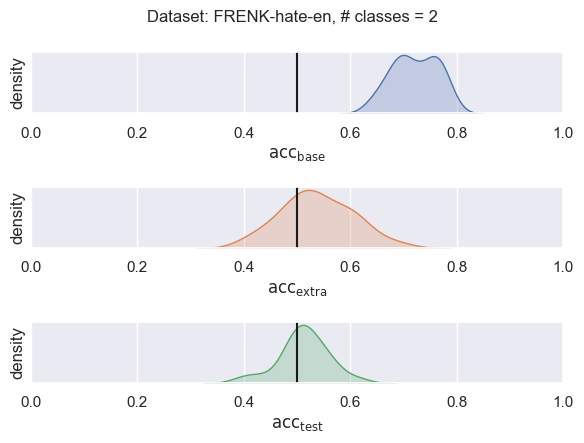

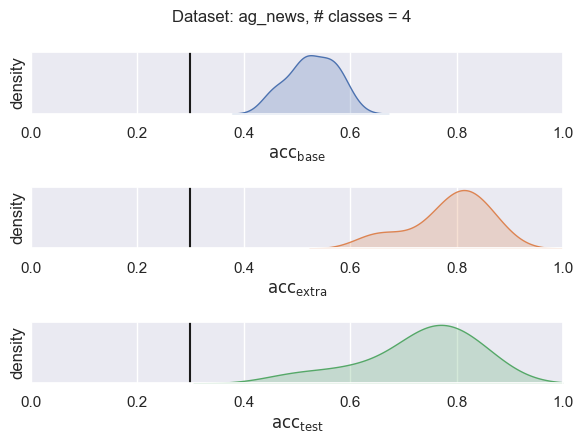

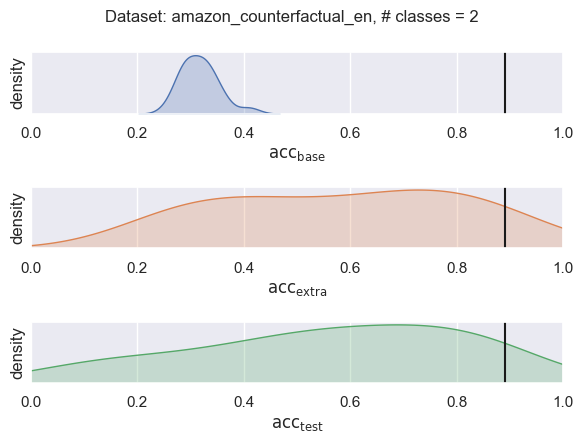

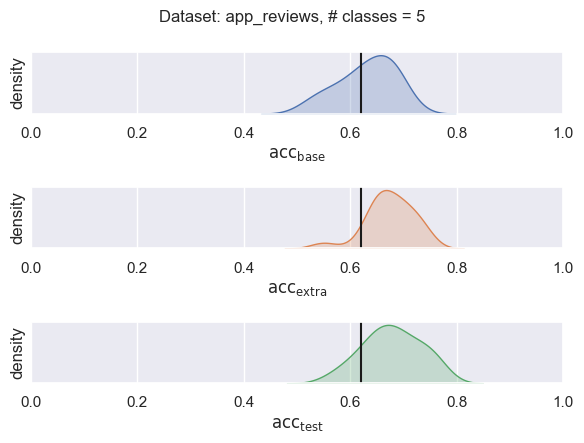

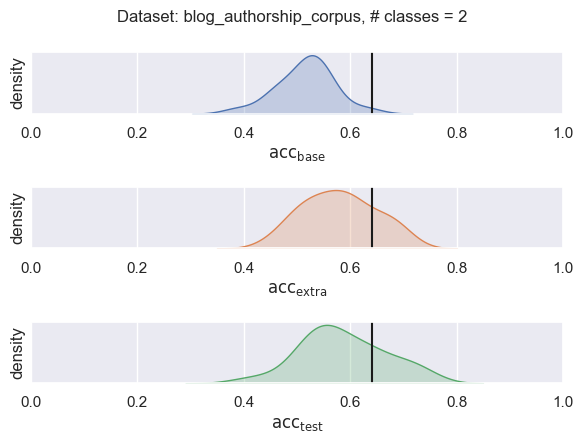

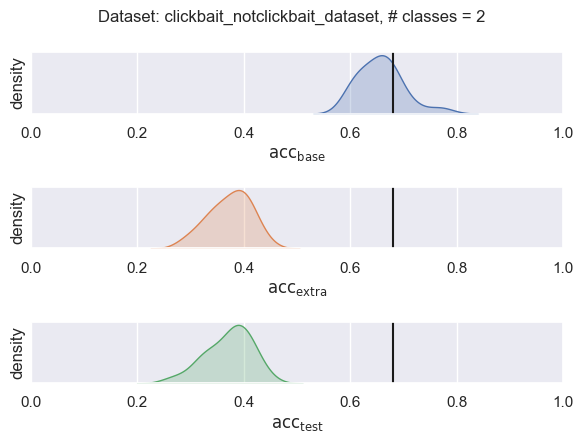

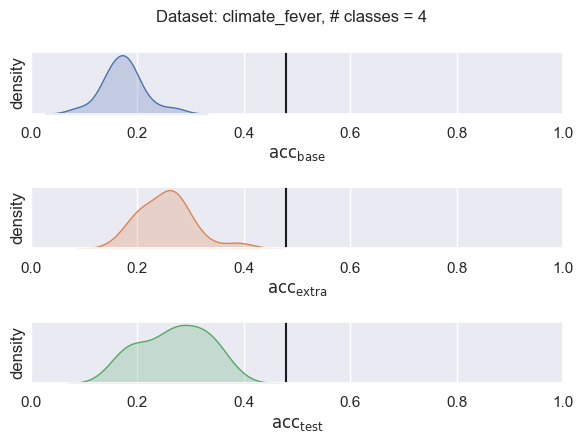

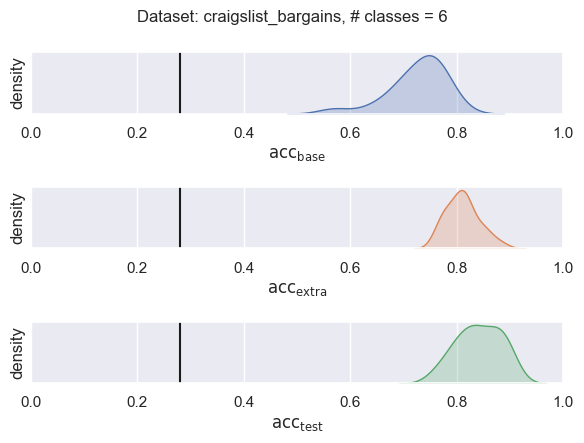

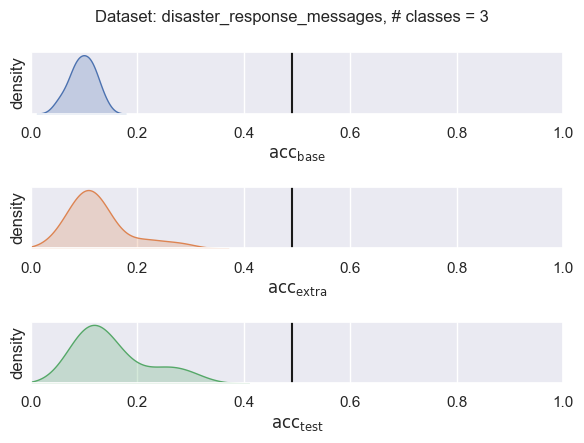

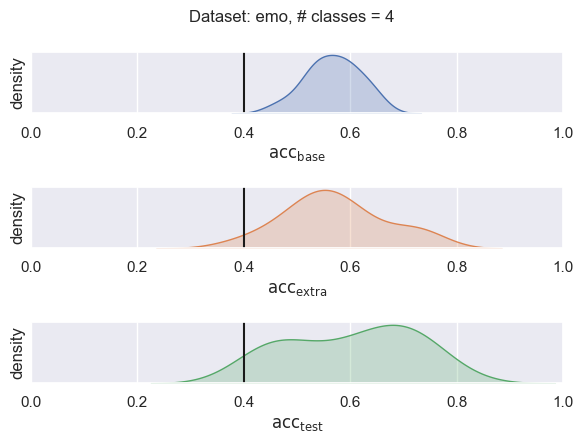

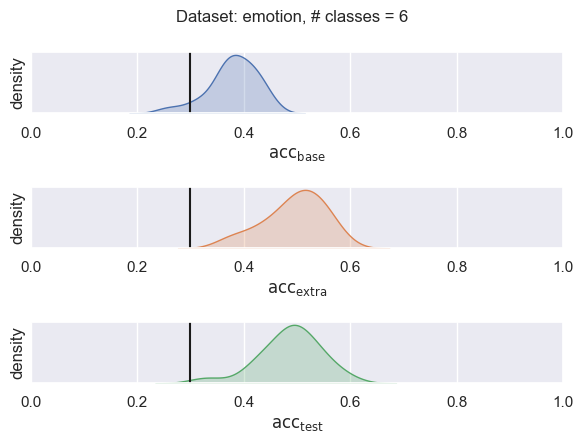

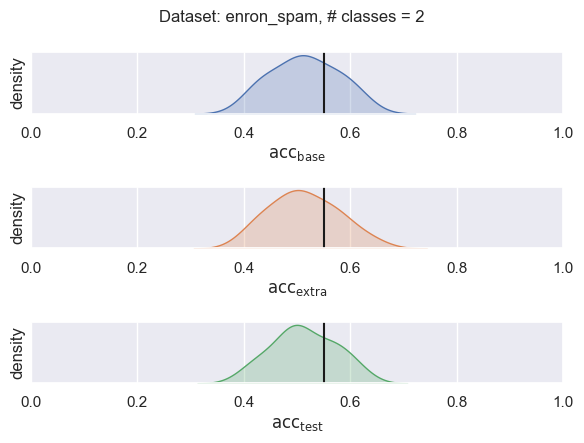

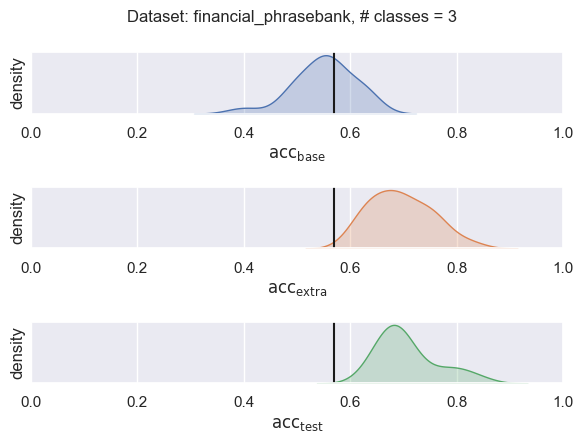

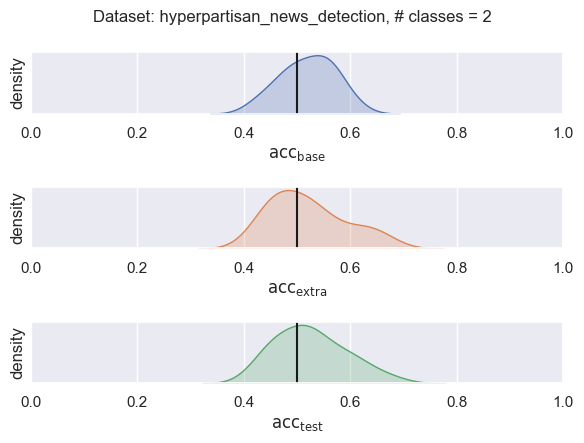

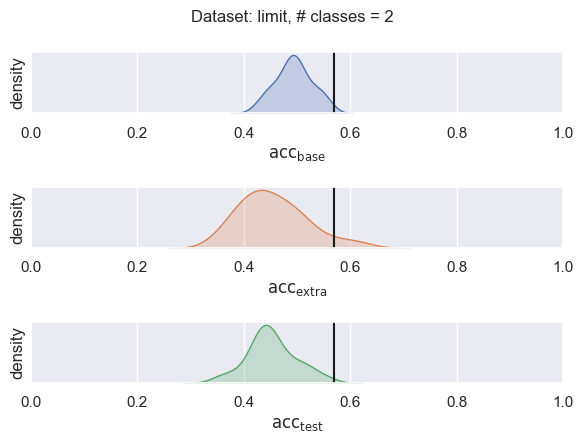

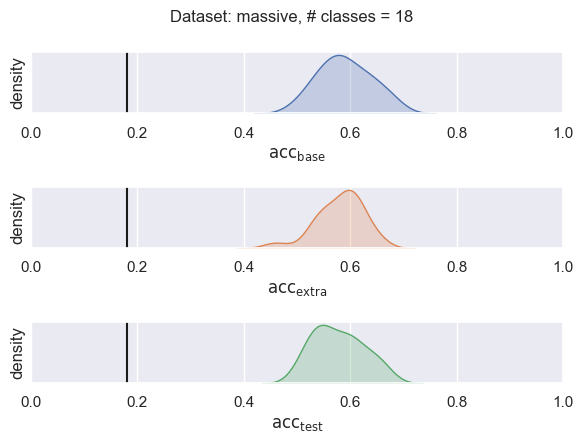

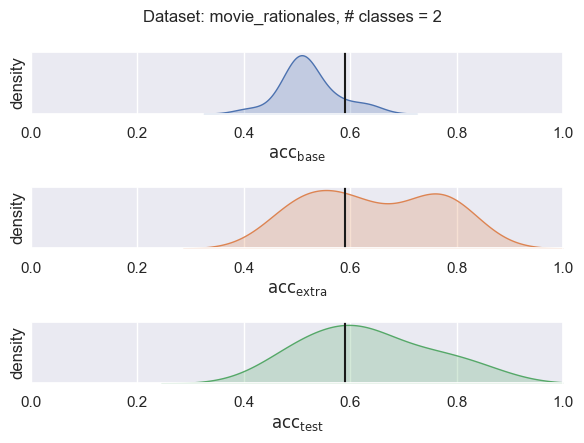

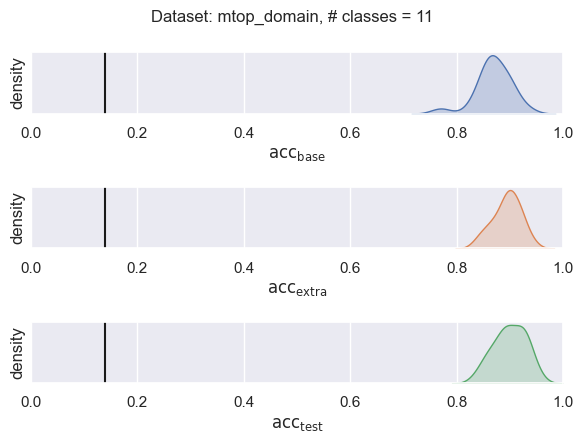

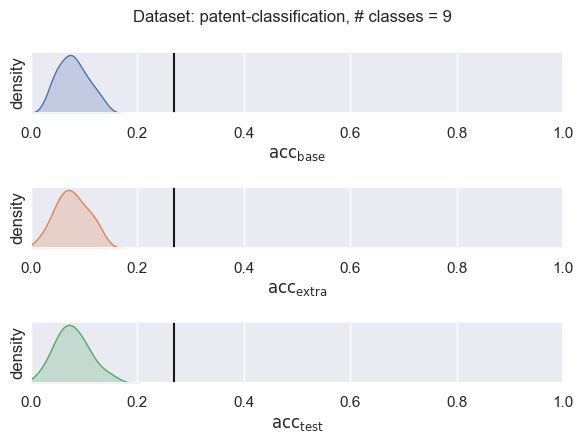

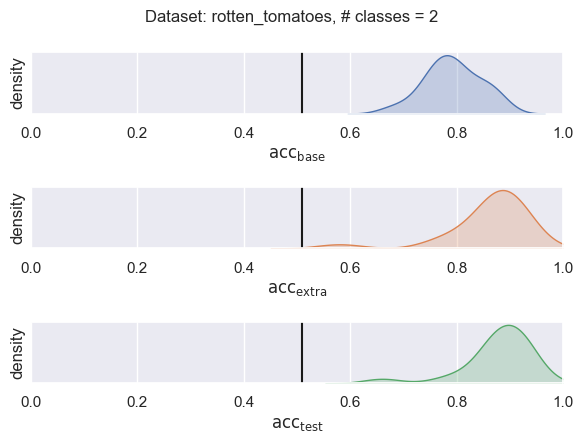

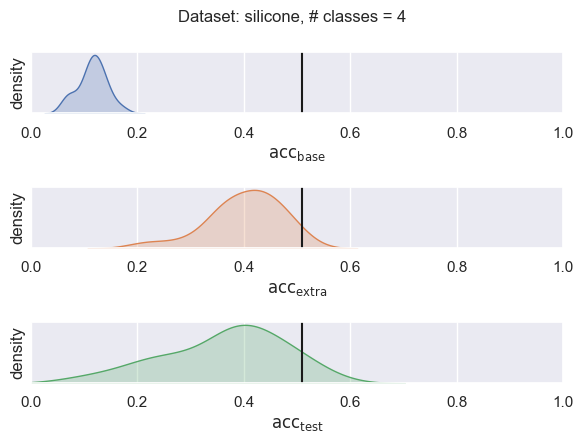

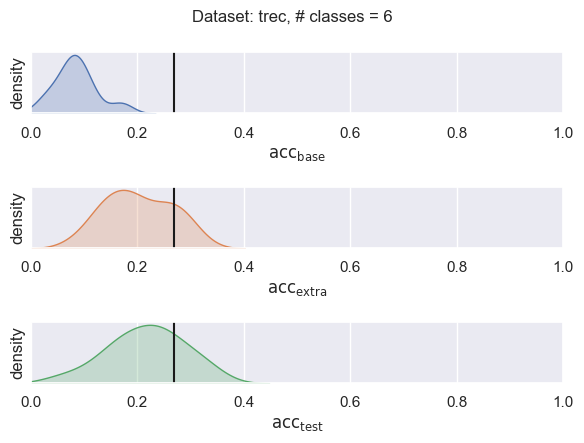

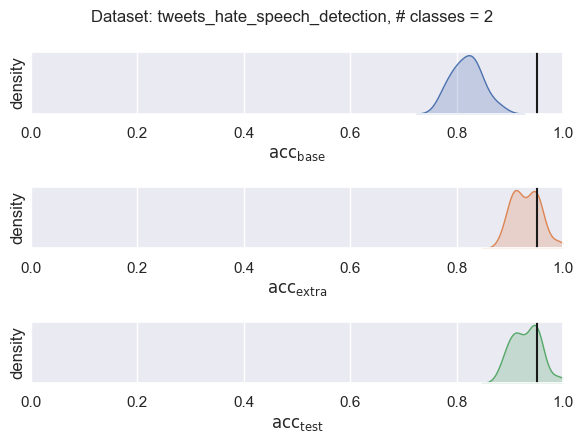

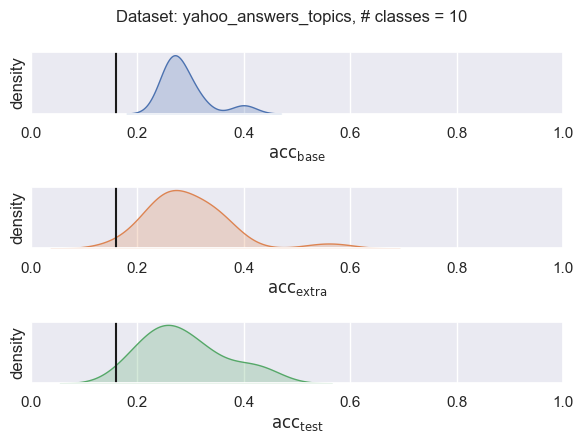

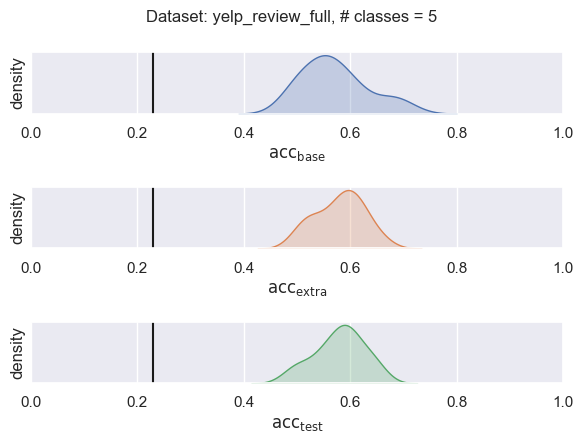

In [8]:
p_values = analyze_all_separately(accuracy_df)

In [9]:
p_values_adjusted = pl.DataFrame(
    {
        "dataset": accuracy_df["dataset"].unique(maintain_order=True),
        "p-value": fdrcorrection(p_values)[1],
    }
)
pl.Config.set_fmt_str_lengths(200)

with pl.Config(tbl_rows=-1):
    print(p_values_adjusted.with_columns(pl.col("p-value").round(3)).sort("p-value"))

shape: (25, 2)
┌────────────────────────────────┬─────────┐
│ dataset                        ┆ p-value │
│ ---                            ┆ ---     │
│ str                            ┆ f64     │
╞════════════════════════════════╪═════════╡
│ craigslist_bargains            ┆ 0.504   │
│ financial_phrasebank           ┆ 0.504   │
│ app_reviews                    ┆ 0.696   │
│ climate_fever                  ┆ 0.696   │
│ disaster_response_messages     ┆ 0.696   │
│ emo                            ┆ 0.696   │
│ mtop_domain                    ┆ 0.696   │
│ rotten_tomatoes                ┆ 0.696   │
│ trec                           ┆ 0.696   │
│ blog_authorship_corpus         ┆ 0.825   │
│ hyperpartisan_news_detection   ┆ 0.825   │
│ patent-classification          ┆ 0.883   │
│ amazon_counterfactual_en       ┆ 0.912   │
│ enron_spam                     ┆ 0.912   │
│ limit                          ┆ 0.912   │
│ massive                        ┆ 0.912   │
│ movie_rationales               ┆ 0.912

Note: after adjustment, it's wrong to interpret 1 - p the same way we would an
unadjusted p-value.